In [1]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

# basic imports
from platform import python_version
import tensorflow as tf 
import tensorflow_io as tfio
import os
import numpy as np
import datetime
import tensorflow_hub as hub

from keras.utils import dataset_utils
import matplotlib.pyplot as plt

from IPython import display
import librosa
import glob
import imageio
import PIL
import tensorflow as tf
import time

import baseline_config

# print system information
print('Python Version        : ', python_version())
print('TensorFlow Version    : ', tf.__version__)
print('TensorFlow IO Version : ', tfio.__version__)
print('Librosa Version       : ', librosa.__version__)

Python Version        :  3.8.16
TensorFlow Version    :  2.10.1
TensorFlow IO Version :  0.27.0
Librosa Version       :  0.10.0


In [2]:
def enforce_memory_limit(mem_mb):
  # enforce memory limit on GPU

  gpus = tf.config.experimental.list_physical_devices('GPU')
  if gpus:
    try:
      tf.config.experimental.set_virtual_device_configuration(
          gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=mem_mb)])
      print(f"vram limit set to {mem_mb}MB")
    except RuntimeError as e:
      print(e)
      
# enforce max 5 GB memory on GPU for this notebook
# enforce_memory_limit(5120)

In [3]:
########################################################################################
# MODEL PARAMETERS
########################################################################################
MODEL_INPUT_IMAGE_WIDTH = 256
MODEL_INPUT_IMAGE_HEIGHT = 256
MODEL_INPUT_IMAGE_CHANNELS = 3

In [4]:
def paths_and_labels_to_dataset(image_paths,labels,num_classes):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    img_ds = path_ds.map(
        lambda path: tf.io.read_file(path), 
        num_parallel_calls=tf.data.AUTOTUNE
    )
    label_ds = dataset_utils.labels_to_dataset(
        labels, 
        'categorical', 
        num_classes)
    img_ds = tf.data.Dataset.zip((img_ds, label_ds))
    return img_ds

def create_dataset(subset):
    image_paths, labels, class_names = dataset_utils.index_directory(
            baseline_config.dataset_path + subset,
            labels="inferred",
            formats=('.pt'),
            class_names=None,
            shuffle=False,
            seed=42,
            follow_links=False)

    dataset = paths_and_labels_to_dataset(
        image_paths=image_paths,
        labels=labels,
        num_classes=len(class_names))
    
    return dataset, class_names

train_dataset, class_names = create_dataset('TRAIN/')
test_dataset, _            = create_dataset('TEST/')
validation_dataset, _      = create_dataset('VALIDATION/')
print("class names: ", class_names)

Found 12384 files belonging to 5 classes.
Found 54 files belonging to 5 classes.
Found 817 files belonging to 5 classes.
class names:  ['brant', 'jabwar', 'sheowl', 'spodov', 'wiltur']


In [5]:

def dataset_transforms(image, label):
    # reshape into standard 3 channels
    image = tf.io.parse_tensor(image, tf.float32)
    image = tf.expand_dims(image, -1)
    
    # most pre-trained model expect 3 color channels
    image = tf.repeat(image, MODEL_INPUT_IMAGE_CHANNELS, axis=2)
    
    image = tf.ensure_shape(image, [216, 128, MODEL_INPUT_IMAGE_CHANNELS])
    image = tf.image.resize(image, (MODEL_INPUT_IMAGE_WIDTH,MODEL_INPUT_IMAGE_HEIGHT), 
                            method=tf.image.ResizeMethod.BICUBIC)
    
    # for some reason the melspecs seem rotated by 90 degrees. This corrects that.
    image = tf.image.rot90(image, k=1)
    
    # rescale to range [0,1]
    image = image - tf.reduce_min(image) 
    image = image / (tf.reduce_max(image)+0.00001)
    
    # image with noise
    noise_strength = tf.random.uniform(shape=(), minval=0, maxval=0.06)
    image_noise = image + tf.random.normal(image.shape,0,noise_strength)
    image_noise = image_noise - tf.reduce_min(image_noise) 
    image_noise = image_noise / (tf.reduce_max(image_noise)+0.00001)
    
    return image_noise,image

train_dataset_b = ( 
                  train_dataset       
                  .shuffle(2000)
                  .map(dataset_transforms)
                  .batch(baseline_config.batch_size)          
                )

validation_dataset_b = ( 
                  validation_dataset
                  .shuffle(2000)
                  .map(dataset_transforms)
                  .batch(baseline_config.batch_size)
                )

test_dataset_b = ( 
                  test_dataset
                  .map(dataset_transforms)
                  .batch(baseline_config.batch_size)
                )

 item and label shapes (32, 256, 256, 3) , (32, 256, 256, 3)
 min and max pixel value 0.0, 0.9999924302101135


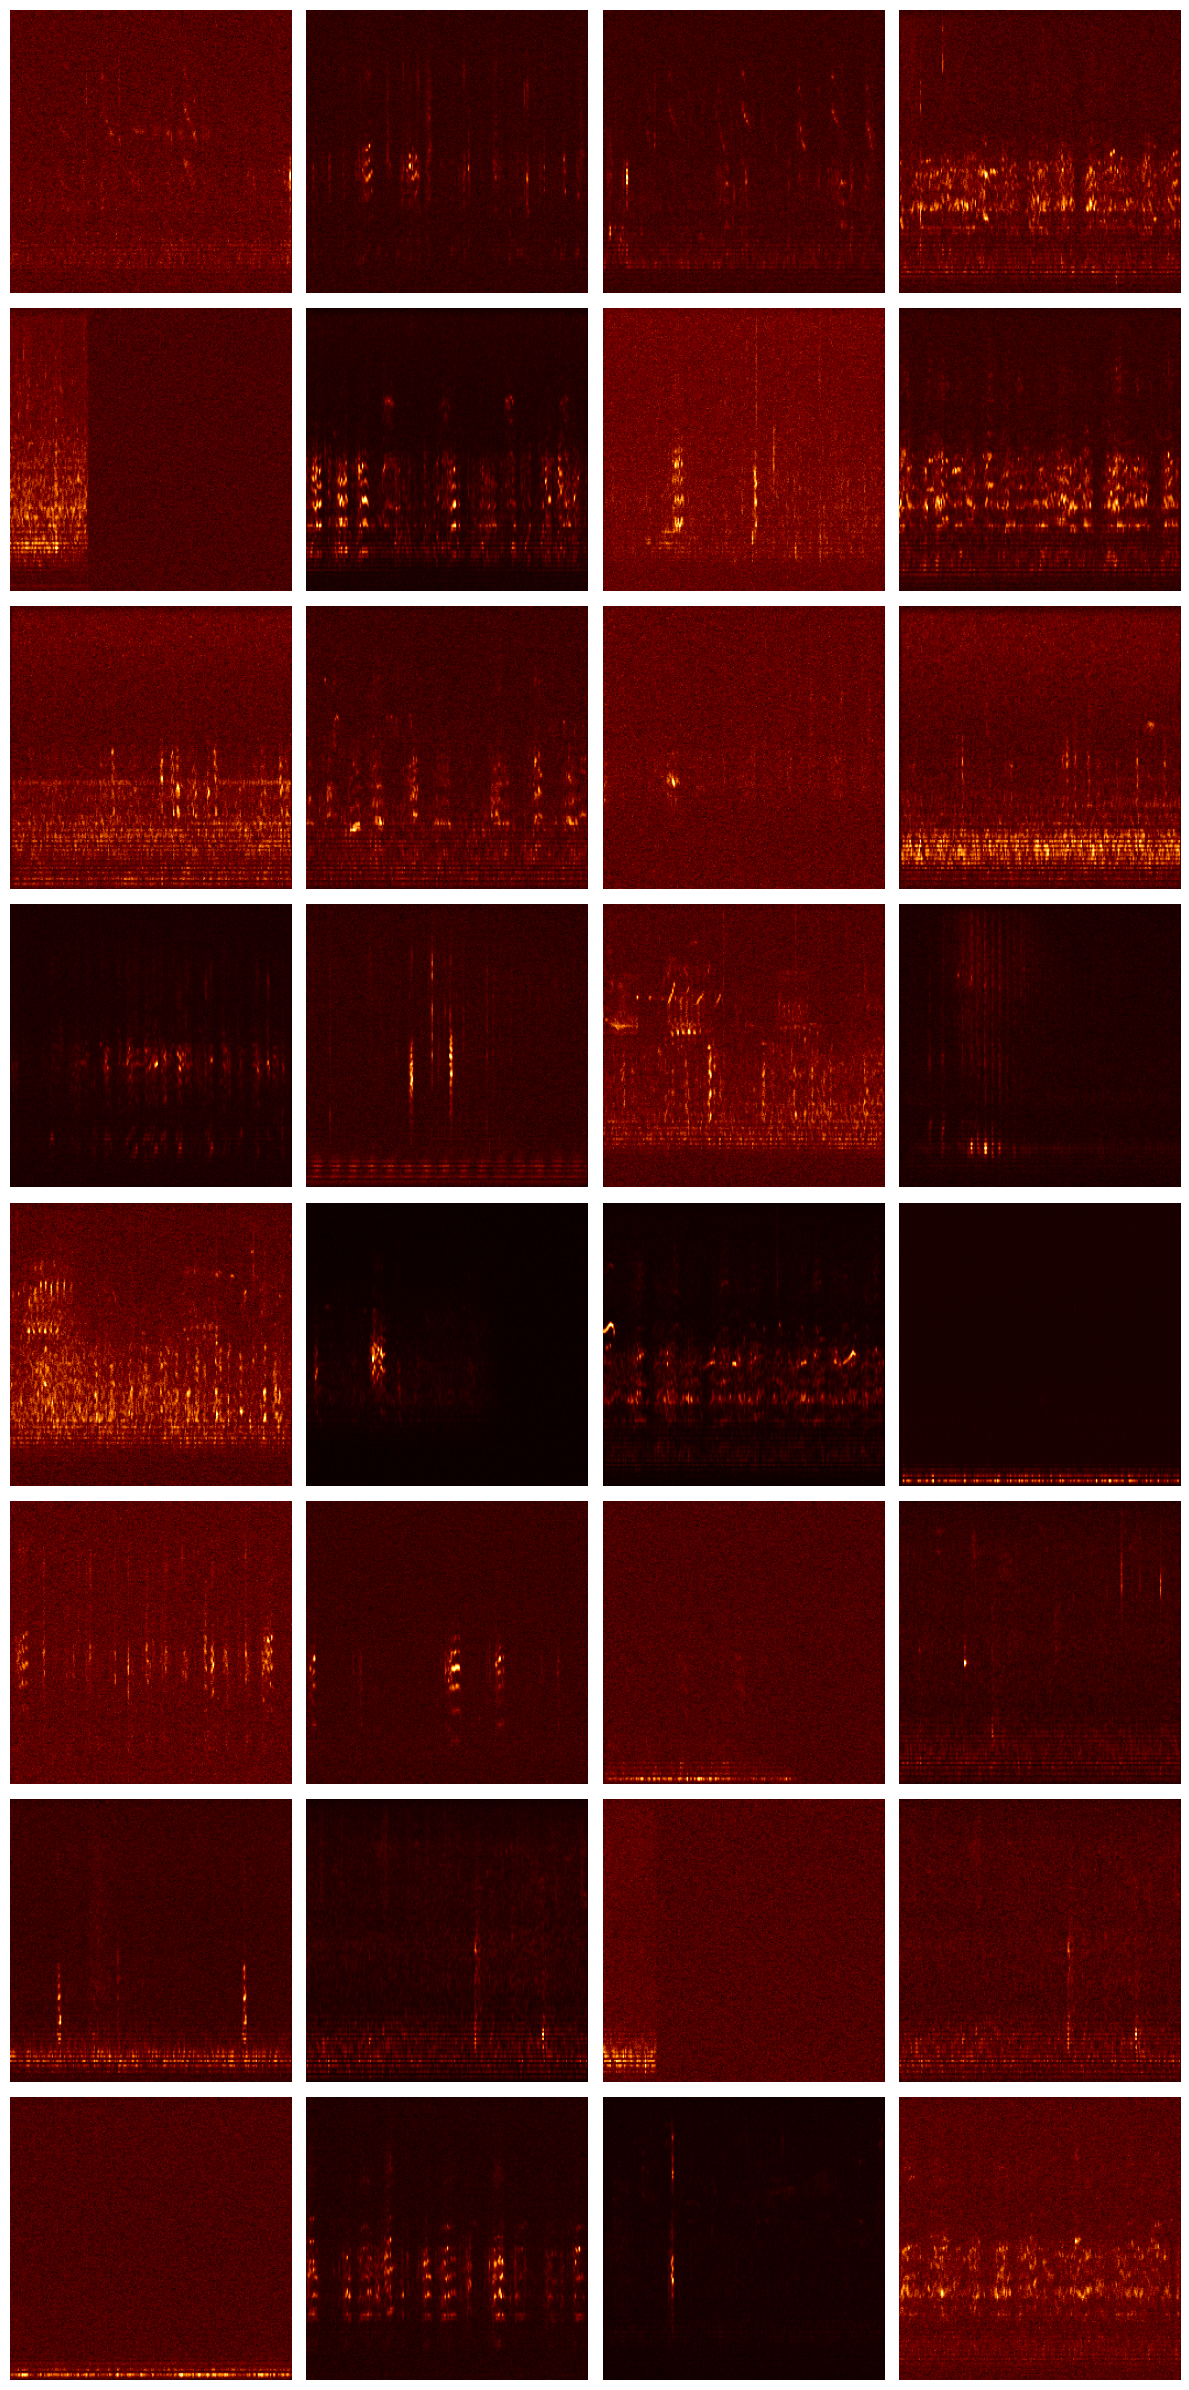

In [6]:
# take 1 batch worth of data from the dataset
for item,lbl in train_dataset_b.take(1):
    print(f' item and label shapes {item.shape} , {lbl.shape}')
    print(f' min and max pixel value {np.min(item)}, {np.max(item)}')
    
    grid_size = (8, 4)
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 24))
    
    # lets look at what the batch contains
    b = 0
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            melspec = item[b,:,:,0]
            ax = axes[i, j]
            plot_index = i * grid_size[1] + j
            ax.imshow(melspec, cmap='afmhot', aspect='auto')
            #ax.set_title(f'Label {lbl[b,:]}')
            ax.axis('off')
            b = b + 1
            
    plt.tight_layout()
    plt.show()

In [7]:
# inspired by https://www.tensorflow.org/tutorials/generative/autoencoder

class Denoise(tf.keras.models.Model):
  def __init__(self):
    
    super(Denoise, self).__init__()
    
    ks=3
    stride =2
    
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(MODEL_INPUT_IMAGE_HEIGHT, MODEL_INPUT_IMAGE_WIDTH, MODEL_INPUT_IMAGE_CHANNELS)),
      
      tf.keras.layers.Conv2D(64, (ks,ks), activation=tf.nn.leaky_relu, padding='same', strides=stride),
      tf.keras.layers.BatchNormalization(),
      
      tf.keras.layers.Dropout(rate=0.5),
      
      tf.keras.layers.Conv2D(128, (ks,ks), activation=tf.nn.leaky_relu, padding='same', strides=stride),
      tf.keras.layers.BatchNormalization(),
      
      tf.keras.layers.Conv2D(256, (ks,ks), activation=tf.nn.leaky_relu, padding='same', strides=stride),
      tf.keras.layers.BatchNormalization(),
    ])

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dropout(rate=0.5),
      
      tf.keras.layers.Conv2DTranspose(256, kernel_size=ks, strides=stride, activation=tf.nn.leaky_relu, padding='same'),
      tf.keras.layers.BatchNormalization(),
      
      tf.keras.layers.Conv2DTranspose(128, kernel_size=ks, strides=stride, activation=tf.nn.leaky_relu, padding='same'),
      tf.keras.layers.BatchNormalization(),
      
      tf.keras.layers.Conv2DTranspose(64, kernel_size=ks, strides=stride, activation=tf.nn.leaky_relu, padding='same'),
      tf.keras.layers.BatchNormalization(),
      
      tf.keras.layers.Conv2D(MODEL_INPUT_IMAGE_CHANNELS, kernel_size=(ks, ks), activation='sigmoid', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [8]:
denoiser = Denoise()

denoiser.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), 
                 loss=tf.keras.losses.MeanSquaredError())

In [9]:
denoiser.fit(train_dataset_b,
                epochs=20,
                validation_data=validation_dataset_b)

Epoch 1/20
387/387 [==============================] - 94s 225ms/step - loss: 0.0754 - val_loss: 0.0841
Epoch 2/20
387/387 [==============================] - 86s 221ms/step - loss: 0.0152 - val_loss: 0.0044
Epoch 3/20
387/387 [==============================] - 86s 222ms/step - loss: 0.0058 - val_loss: 0.0027
Epoch 4/20
387/387 [==============================] - 86s 222ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 5/20
387/387 [==============================] - 86s 221ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 6/20
387/387 [==============================] - 86s 222ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/20
387/387 [==============================] - 86s 222ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 8/20
387/387 [==============================] - 86s 222ms/step - loss: 0.0011 - val_loss: 8.1826e-04
Epoch 9/20
387/387 [==============================] - 86s 222ms/step - loss: 9.7382e-04 - val_loss: 8.0626e-04
Epoch 10/20
387/387 [==============================] - 86s 22

In [10]:
def softmax(arr):
    # Calculate the exponent of each element in the array
    exp_arr = np.exp(arr)
    
    # Sum the exponentials across the entire array
    exp_sum = np.sum(exp_arr)
    
    # Divide each element's exponential by the sum of exponentials across the entire array
    softmax_arr = exp_arr / exp_sum
    
    return softmax_arr

def set_border_pixels(arr, w, x):
    if w < 0:
        raise ValueError("Border width must be non-negative.")
    
    # no pixels to set
    if w == 0:
        return arr

    # Set top and bottom borders
    arr[:w, :] = x
    arr[-w:, :] = x

    # Set left and right borders
    arr[:, :w] = x
    arr[:, -w:] = x

    return arr

 out shape (32, 256, 256, 3)


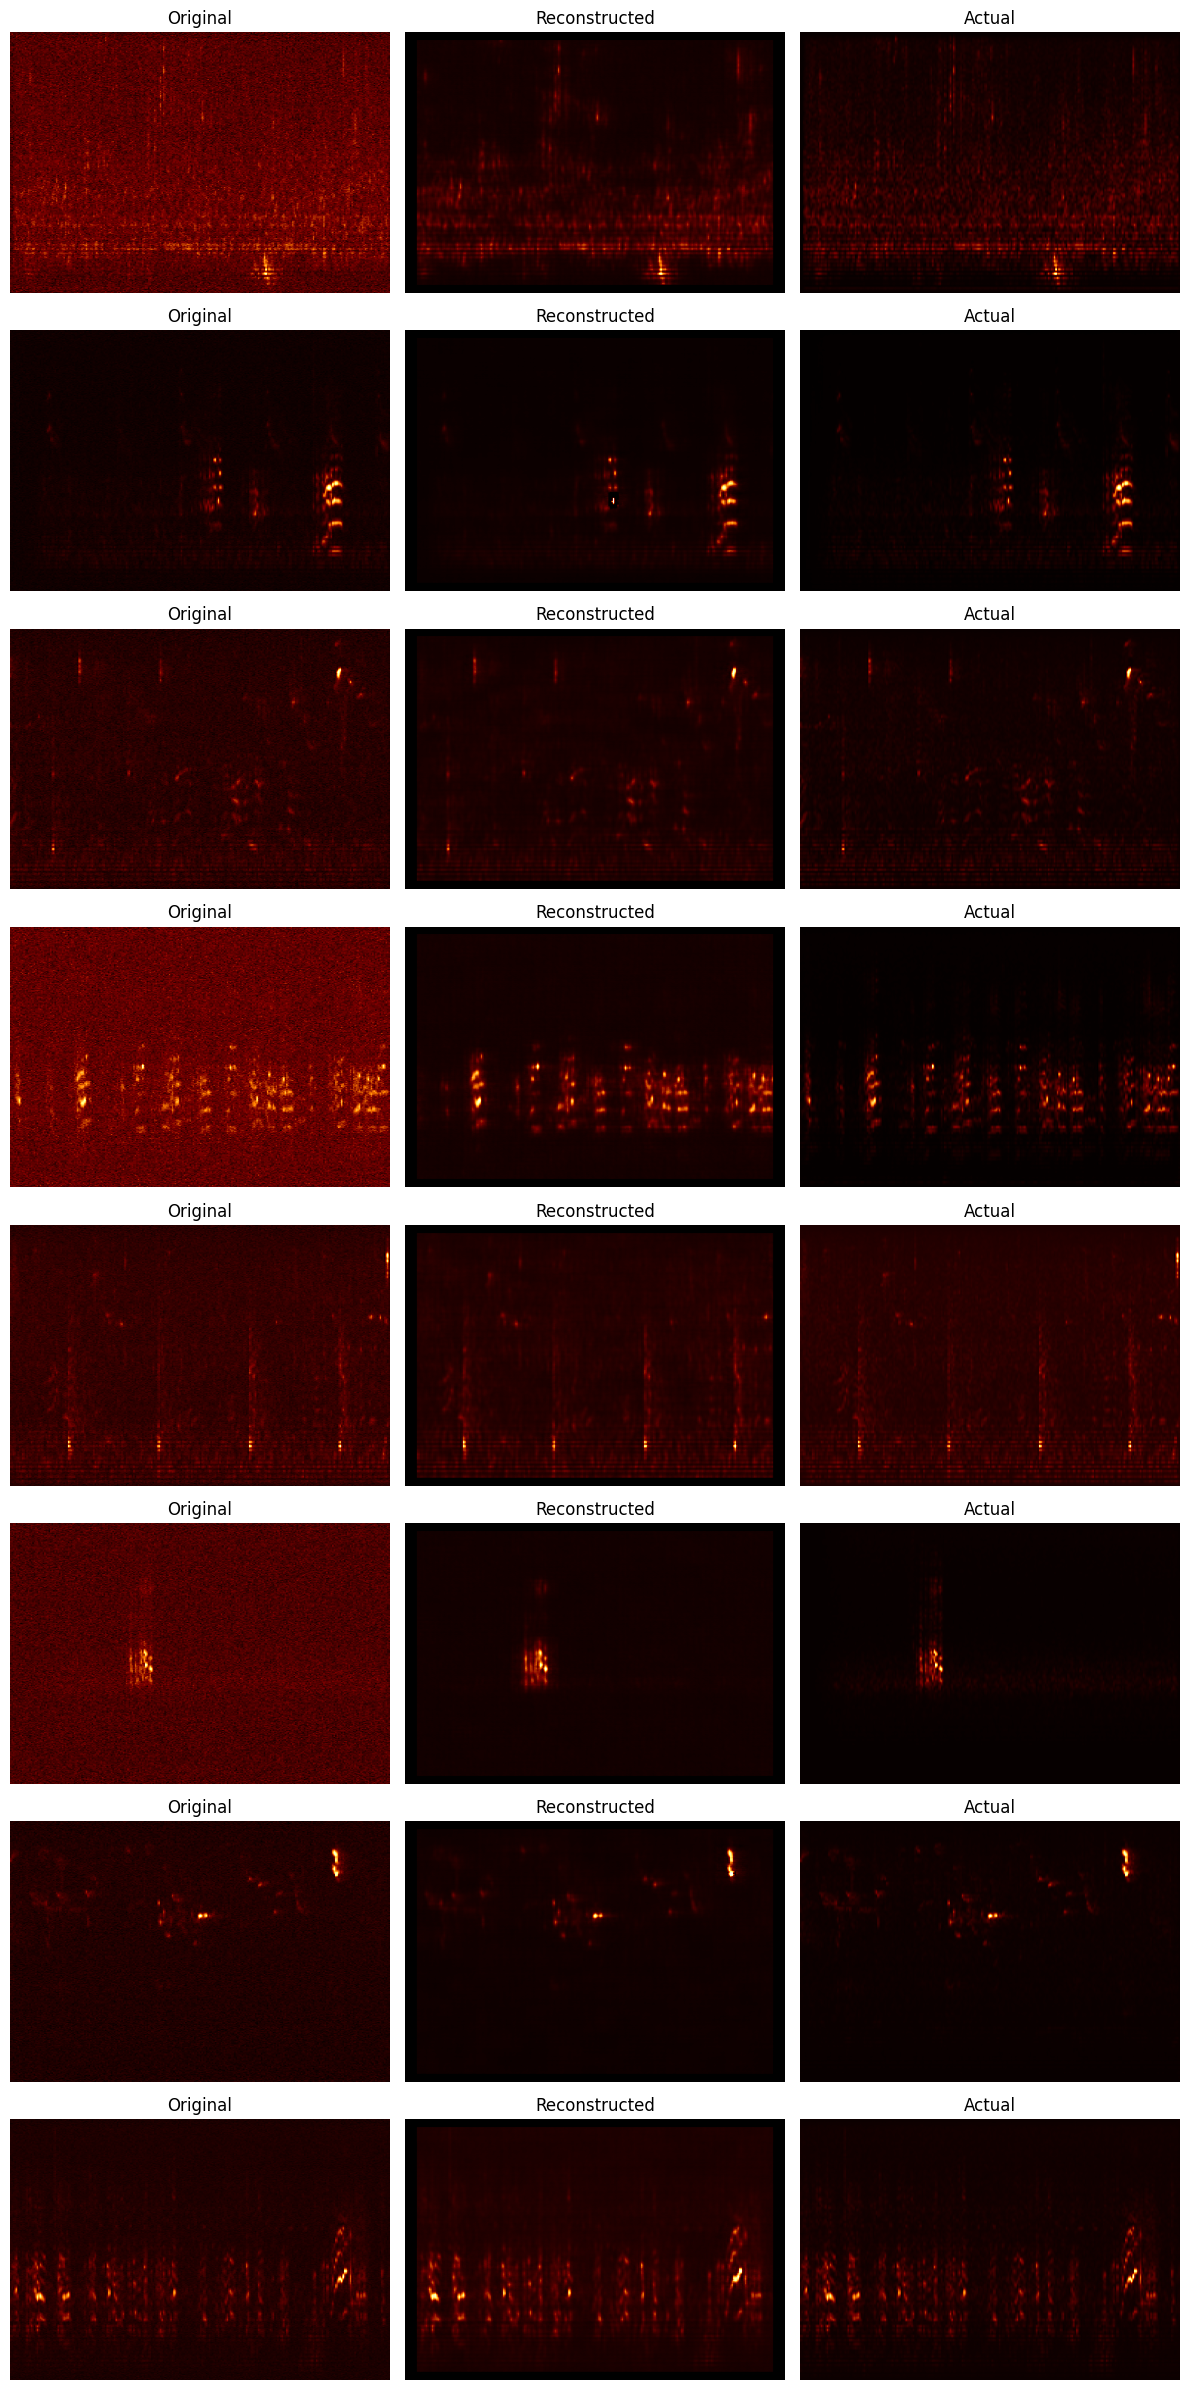

In [11]:
# take 1 batch worth of data from the dataset
for img_noise,img in train_dataset_b.take(1):
    #print(f' item and label shapes {item.shape} , {lbl.shape}')
    #print(f' min and max pixel value {np.min(item)}, {np.max(item)}')
    
    out = denoiser(img_noise)
    #z_recon = feature_model.reparameterize(encoded)
    #out = feature_model.decode(encoded)
    
    print(f' out shape {out.shape}')
    
    grid_size = (8,3) # 8 rows, 3 cols
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 24))
    
    # lets look at what the batch contains
    b = 0
    for i in range(grid_size[0]):
        j=0
        melspec = img_noise[b,:,:,0]
        ax = axes[i, j]
        plot_index = i * grid_size[1] + j
        ax.imshow(melspec, cmap='afmhot', aspect='auto')
        ax.set_title(f'Original')
        ax.axis('off')
        
        j=1
        # melspec = out[b,:,:,0]-np.min(out[b,:,:,0])
        melspec = set_border_pixels(out[b,:,:,0].numpy(),8,0)
        melspec = melspec / (np.max(melspec) + 0.0001)
        ax = axes[i, j]
        plot_index = i * grid_size[1] + j
        ax.imshow(melspec, cmap='afmhot', aspect='auto')
        ax.set_title(f'Reconstructed')
        ax.axis('off')
        
        j=2
        melspec = img[b,:,:,0]
        # melspec = softmax(out[b,:,:,0])
        #print(out[b,:,:,0])
        #print(softmax(out[b,:,:,0]))
        ax = axes[i, j]
        plot_index = i * grid_size[1] + j
        ax.imshow(melspec, cmap='afmhot', aspect='auto')
        ax.set_title(f'Actual')
        ax.axis('off')        
               
        b = b + 1
            
    plt.tight_layout()
    plt.show()